# Testing percentiles

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1cdpblu/comment/l1e9zaf/).

> I have two different samples (about 100 observations per sample) drawn from the same population (or that's what I hypothesize; the populations may in fact be different). The samples and population are approximately normal in distribution.
>
> I want to estimate the 85th percentile value for both samples, and then see if there is a statistically significant difference between these two values. I cannot use a normal z- or t-test for this, can I? It's my current understanding that those tests would only work if I were comparing the means of the samples.
>
> As an extension of this, say I wanted to compare one of these 85th percentile values to a fixed value; again, if I was looking at the mean, I would just construct a confidence interval and see if the fixed value fell within it...but the percentile stuff is throwing me for a loop.
>
> This is [...] related to a research project I'm working on (in my job).


There are two questions here.
The first is about testing a difference in percentiles between two groups.
The second is about the difference between a percentile from an observed sample and an expected value.
Let's see what we can do.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/test_percentile.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

## Data

Since OP didn't provide a dataset, we have to generate one.
I'll draw two samples from Gaussian distributions with the same standard deviation and different means.

In [3]:
np.random.seed(17)

mu = 10
sigma = 2

group1 = np.random.normal(mu, sigma, size=100)
group2 = np.random.normal(mu+1, sigma, size=100)

Here's what the distributions of the groups look like.

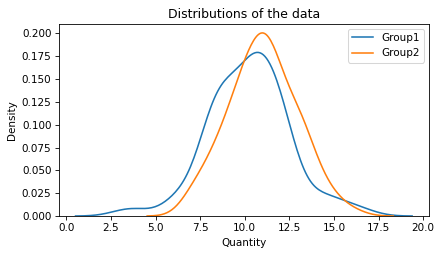

In [4]:
sns.kdeplot(group1, label='Group1')
sns.kdeplot(group2, label='Group2')

decorate(xlabel='Quantity',
         ylabel='Density',
         title='Distributions of the data')

If we compute the 85th percentile in both groups, we see a difference, as expected.

In [5]:
stat1 = np.percentile(group1, 85)
stat2 = np.percentile(group2, 85)
stat1, stat2

(12.241826987876475, 13.057003640622057)

And here's the size of the difference.

In [6]:
actual_diff = stat2 - stat1
actual_diff

0.8151766527455813

Let's see if a difference of that size would be likely if the two samples were actually drawn from the same distribution.

## Testing the Difference

When we test a difference between two groups, the usual model of the null hypothesis is that the groups are actually identical.
If that's true, the two samples came from the same distribution, so we can combine them into a single sample.

In [7]:
pooled = np.concatenate([group1, group2])
n, m = len(group1), len(group2)

Now we can simulate the null hypothesis by permutation -- that is, by shuffling the pooled data and splitting it into two groups with the same sizes as the original.
The following function generates two samples under this assumption, and returns the difference in their 85th percentiles.

In [8]:
def simulate_percentile_difference():
    np.random.shuffle(pooled)
    shuffled1 = pooled[:n]
    shuffled2 = pooled[n:]
    diff = np.percentile(shuffled1, 85) - np.percentile(shuffled2, 85)
    return diff

If we call it many times, the result is a sample from the distribution of differences under the null hypothesis.

In [9]:
np.random.seed(19)
sample_diff = [simulate_percentile_difference() for i in range(1001)]

Here's what it looks like, with a vertical line at the observed difference.

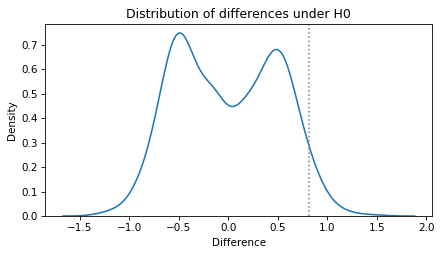

In [10]:
sns.kdeplot(sample_diff, label='')
plt.axvline(actual_diff, ls=':', color='gray')
decorate(xlabel='Difference',
         ylabel='Density',
         title='Distribution of differences under H0')

To estimate a one-sided p-value, we can compute the fraction of the sample that exceeds the actual difference.

In [11]:
p_value_one_sided = (sample_diff >= actual_diff).mean()
p_value_one_sided

0.04195804195804196

Or, for a two-sided p-value, we can compute the fraction of the sample that exceeds the actual difference in absolute value.

In [12]:
p_value_two_sided = (np.abs(sample_diff) > actual_diff).mean()
p_value_two_sided

0.07892107892107893

In this example, the result of the one-sided test would be considered significant at the 5% "significance level", but the two-sided test would not.
So which is it?

In my opinion, it is not worth worrying about.
My interpretation of the results is the same either way: under the null hypothesis, a difference as big as the one we saw would be unlikely.
But we can't rule out the possibility that the groups are actually identical, and the difference is due to random variation.

## Testing a fixed value

Now let's turn to the second problem.
Suppose we have reason to think that the actual value of the 85th percentile is 12.3, and we would like to know whether the data contradict this hypothesis.

In [13]:
expected = 12.3

We'll test `group1` first.
Here's the 85th percentile of `group1` and its difference from the expected value.

In [14]:
stat1 = np.percentile(group1, 85)
actual_diff1 = stat1 - expected
stat1, actual_diff1

(12.241826987876475, -0.058173012123525325)

Let's see if a difference of this magnitude is likely to happen under the null hypothesis.
One way to model the null hypothesis is to create a dataset that is similar to the observed data, but where the 85th percentile is exactly as expected.
We can do that by shifting the observed data by the observed distance.

In [15]:
shifted = group1 - actual_diff1
np.percentile(shifted, 85)

12.3

The 85th percentile of the shifted data is the expected value, exactly.

Now, to generate samples under the null hypothesis, we can use the following function, which takes a sample, shifts it to have the expected value of the 85th percentile, generates a bootstrap resample of the shifted values, and returns the difference between the 85th percentile of the sample and the expected value.

In [39]:
def bootstrap_percentile(group):
    stat = np.percentile(group, 85) - expected
    shifted = group - stat
    resampled = np.random.choice(shifted, size=len(group), replace=True)
    return np.percentile(resampled, 85) - expected

If we call this function many times, we get a sample of the differences we expect under the null hypothesis.

In [40]:
np.random.seed(17)
sample1 = [bootstrap_percentile(group1) for i in range(1001)]

The following function shows the distribution of the sample with a vertical line at the observed value.

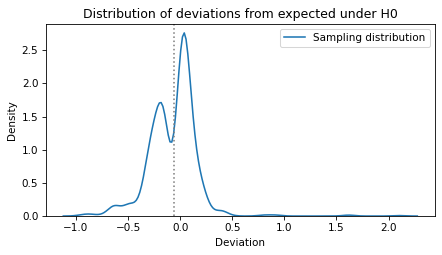

In [41]:
sns.kdeplot(sample1, label='Sampling distribution')
plt.axvline(actual_diff1, ls=':', color='gray')
decorate(xlabel='Deviation',
         ylabel='Density',
         title='Distribution of deviations from expected under H0')

Without computing a p-value, we can see that a difference as big as `actual_diff1` is entirely plausible until the null hypothesis.
We can confirm that by computing a one-sided p-value.

In [42]:
p_value_one_side = (sample1 < actual_diff1).mean()
p_value_one_side

0.4405594405594406

So the observed difference in the first group is not statistically significant.
Now let's do the same thing for the second group.

In [43]:
stat2 = np.percentile(group2, 85)
actual_diff2 = stat2 - expected
actual_diff2

0.7570036406220559

In [44]:
np.random.seed(17)
sample2 = [bootstrap_percentile(group2) for i in range(1001)]

Here's what the distribution of difference looks like under the null hypothesis, with a vertical line at the observed value.

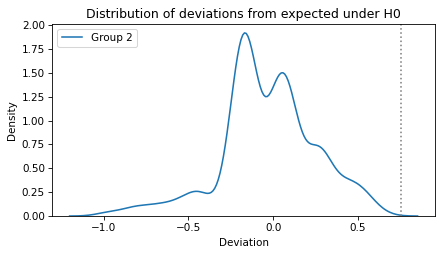

In [45]:
sns.kdeplot(sample2, label='Group 2')
plt.axvline(actual_diff2, ls=':', color='gray')
decorate(xlabel='Deviation',
         ylabel='Density',
         title='Distribution of deviations from expected under H0')

The KDE plot stretches the distribution a little, but actually there are no differences in the sample that exceed the observed value.

In [46]:
np.max(sample2), actual_diff2

(0.6391539586773582, 0.7570036406220559)

We can conclude that a difference as big as that is very unlikely under the null hypothesis.
There's not much point in computing a p-value more precisely than that, but if it's required, we can estimate it if we assume that the tail of the sampling distribution is roughly Gaussian.
In that case, we can fit a KDE to the sampling distribution like this.

In [47]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(sample2)

And use a `Pmf` object to approximate the estimated density.

In [48]:
from empiricaldist import Pmf

qs = np.linspace(-2, 2, 201)
ps = kde.evaluate(qs)
pmf = Pmf(ps, qs)
pmf.normalize()

49.99999999999998

Then we can use the corresponding CDF to compute the probability of a value that exceeds the observed difference.

In [49]:
cdf = pmf.make_cdf()
p_value = 1 - cdf(actual_diff)
p_value

3.319666203671634e-05

So the p-value is quite small.

## Model-based resampling

The bootstrap method in the previous section is a good choice if we are unsure about the distribution of the data, or if there are outliers.

But there is another way we might model the null hypothesis: suppose we want to know if the data might have come from a Gaussian distribution with a given 85th percentile.

We can compute a p-value under this version of the null hypothesis, but only if we make an assumption about the standard deviation of the hypothetical Gaussian distribution.
One way to specify that part of the model is to use the standard deviation of the data.

In [50]:
s = np.std(group1)

Now we need to find a Gaussian distribution with a given standard deviation that has the expected 85th percentile.
We can do that by starting with a distribution that's centered at 0 and then shifting it.

In [51]:
from scipy.stats import norm

dist0 = norm(0, s)
quantile = dist0.ppf(0.85)
quantile

2.3232308032911324

In [52]:
center = expected - quantile
dist = norm(center, s)
dist.ppf(0.85)

12.3

The following function takes one of the groups, fits a hypothetical model to it, generates a sample from the model, and returns the difference between the 85th percentile of the sample and the expected value.

In [53]:
def gaussian_percentile(group):
    s = np.std(group)
    dist0 = norm(0, s)
    quantile = dist0.ppf(0.85)
    center = expected - quantile
    dist = norm(center, s)
    sample = dist.rvs(size=len(group))
    return np.percentile(sample, 85) - expected

If we call this function many times, we get the sampling distribution of the test statistic under the null hypothesis.

In [54]:
np.random.seed(17)
sample3 = [gaussian_percentile(group1) for i in range(1001)]

Here's the distribution of the result, compared to the corresponding distribution from the bootstrapped model.

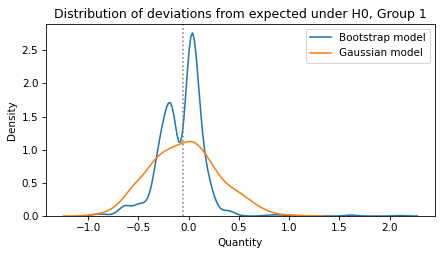

In [55]:
sns.kdeplot(sample1, label='Bootstrap model')
sns.kdeplot(sample3, label='Gaussian model')
plt.axvline(actual_diff1, ls=':', color='gray')
decorate(xlabel='Quantity',
         ylabel='Density',
         title='Distribution of deviations from expected under H0, Group 1')

The shapes of the distributions are different, but their ranges are comparable.
And the conclusion is the same: a difference as big as `actual_diff1` is entirely plausible under the null hypothesis.

In [56]:
p_value_one_side = (sample3 < actual_diff1).mean()
p_value_one_side

0.48451548451548454

Now let's try the same test with Group 2.

In [57]:
np.random.seed(17)
sample4 = [gaussian_percentile(group2) for i in range(1001)]

Here's the result, along with the results from the bootstrap model.

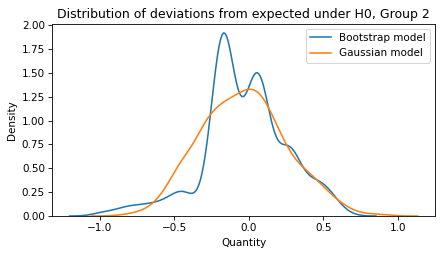

In [58]:
sns.kdeplot(sample2, label='Bootstrap model')
sns.kdeplot(sample4, label='Gaussian model')
decorate(xlabel='Quantity',
         ylabel='Density',
         title='Distribution of deviations from expected under H0, Group 2')

Again, the shapes of the distributions are different, but the conclusion is the same.
A difference as big as `actual_diff2` is unlikely under the null hypothesis.

In [59]:
p_value_one_side = (sample4 > actual_diff2).mean()
p_value_one_side

0.003996003996003996

As usual, the two-sided p-value is bigger by a factor of two, roughly, but the difference never matters in practice.

In [60]:
p_value_two_sided = (np.abs(sample4) > actual_diff2).mean()
p_value_two_sided

0.006993006993006993

Under this model of the null hypothesis, the probability is small that the 85th percentile of the data would exceed the expected value by so much.

## Discussion

Coming soon

*Data Q&A: Answering the real questions with Python*

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)